In [2]:
!pip install numpy==1.26.4 \
             matplotlib==3.9.2 \
             scikit-image==0.24.0 \
             opencv-python-headless==4.10.0.84 \
             mediapipe==0.10.14 \
             torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 \
             Pillow \
             git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-zvumuug_
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-zvumuug_
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 130.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 164.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 132.5 MB/

In [1]:
# ===============================================================
# CELL 2: Imports and helper utilities
# ===============================================================
import os, urllib.request, numpy as np, cv2, matplotlib.pyplot as plt
from PIL import Image
import mediapipe as mp
from skimage import transform as sktf, measure
from segment_anything import sam_model_registry, SamPredictor

def imread_rgb(path):
    im = cv2.imread(path, cv2.IMREAD_COLOR)
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

def show(img, title=""):
    plt.figure(figsize=(6,6)); plt.imshow(img); plt.axis('off'); plt.title(title); plt.show()

def get_line_intersection(p1,p2,p3,p4):
    x1,y1=p1; x2,y2=p2; x3,y3=p3; x4,y4=p4
    denom=(x1-x2)*(y3-y4)-(y1-y2)*(x3-x4)
    if abs(denom)<1e-6: return None
    px=((x1*y2-y1*x2)*(x3-x4)-(x1-x2)*(x3*y4-y3*x4))/denom
    py=((x1*y2-y1*x2)*(y3-y4)-(y1-y2)*(x3*y4-y3*x4))/denom
    return (int(px),int(py))


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [2]:
# ===============================================================
# CELL 3: Download SAM ViT-H weights (~2.5 GB)
# ===============================================================
os.makedirs("weights", exist_ok=True)
ckpt_path = "weights/sam_vit_h_4b8939.pth"
if not os.path.exists(ckpt_path):
    print(" Downloading SAM weights ...")
    urllib.request.urlretrieve(
        "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",
        ckpt_path)
print("SAM weights ready:", ckpt_path)


SAM weights ready: weights/sam_vit_h_4b8939.pth


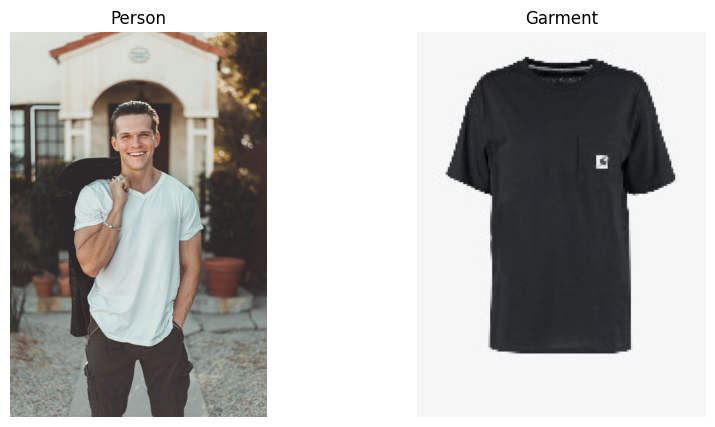

In [4]:
# ===============================================================
# CELL 4: Load input images
# ===============================================================
PERSON_IMG_PATH  = "/content/download.png"
GARMENT_IMG_PATH = "/content/download2.jpg"

person_rgb  = imread_rgb(PERSON_IMG_PATH)
garment_rgb = imread_rgb(GARMENT_IMG_PATH)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(person_rgb);  plt.title("Person");  plt.axis('off')
plt.subplot(1,2,2); plt.imshow(garment_rgb); plt.title("Garment"); plt.axis('off')
plt.show()


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


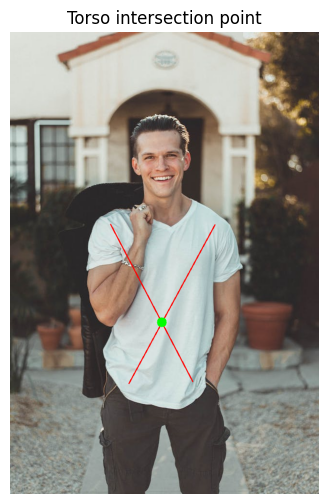

In [5]:
# ===============================================================
# CELL 5: Pose landmarks and intersection (from your notebook)
# ===============================================================
image = person_rgb.copy()
h, w, _ = image.shape
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)
results = pose.process(image)

def get_torso_point(results, w, h):
    if not results.pose_landmarks: return None
    landmarks = results.pose_landmarks.landmark
    p11 = (int(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x * w),
           int(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y * h))
    p12 = (int(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x * w),
           int(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y * h))
    p23 = (int(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x * w),
           int(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y * h))
    p24 = (int(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x * w),
           int(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y * h))
    return p11,p12,p23,p24,get_line_intersection(p11,p24,p12,p23)

p11,p12,p23,p24,intersection_point = get_torso_point(results,w,h)
annotated = image.copy()
cv2.line(annotated,p11,p24,(255,0,0),2)
cv2.line(annotated,p12,p23,(255,0,0),2)
cv2.circle(annotated,intersection_point,10,(0,255,0),-1)
show(annotated,"Torso intersection point")


The above method gave us an intersection point, which we can use to pass it on to SAM model

In [6]:
intersection_point

(314, 602)

/usr/local/lib/python3.12/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


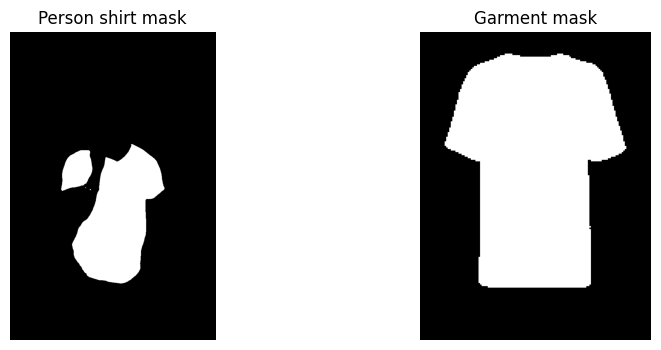

In [7]:
# ===============================================================
# CELL 6: SAM segmentation (person + garment)
# ===============================================================
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry["vit_h"](checkpoint=ckpt_path)
sam.to(device)
predictor = SamPredictor(sam)

def sam_point_mask(img, point_xy):
    predictor.set_image(img)
    pts = np.array([[point_xy[0], point_xy[1]]], dtype=np.float32)
    lbl = np.array([1], dtype=np.int32)
    masks, scores, _ = predictor.predict(point_coords=pts, point_labels=lbl, multimask_output=True)
    return masks[np.argmax(scores)].astype(np.uint8)

shirt_mask   = sam_point_mask(person_rgb, intersection_point)
garment_mask = sam_point_mask(garment_rgb, (garment_rgb.shape[1]/2, garment_rgb.shape[0]/2))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(shirt_mask,cmap='gray'); plt.title("Person shirt mask"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(garment_mask,cmap='gray'); plt.title("Garment mask"); plt.axis('off')
plt.show()


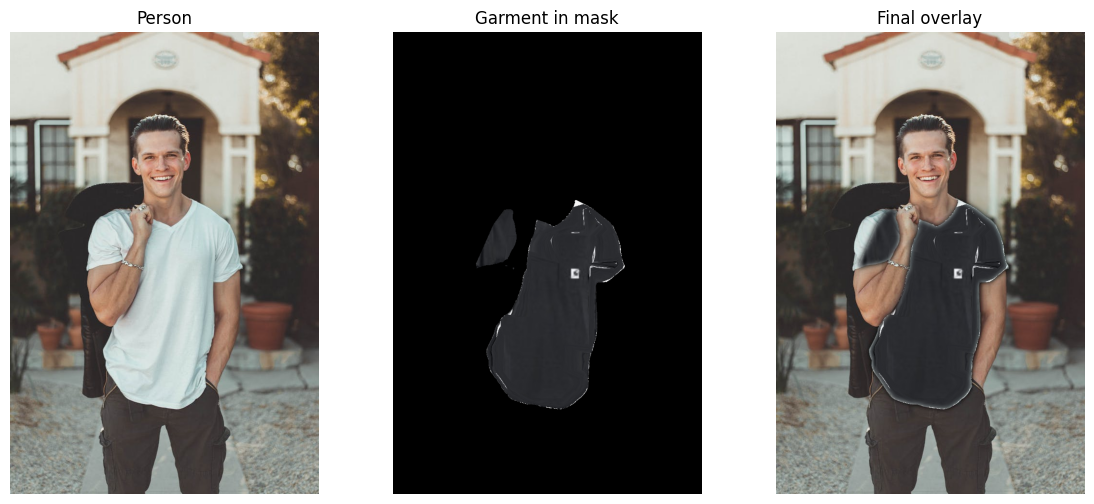

In [13]:
# ===============================================================
# CELL 7 (Exact fit): Triangle-wise texture transfer onto person
# ===============================================================
import numpy as np, cv2
from skimage import transform as sktf

# (Optional) ensure SciPy Delaunay is available
try:
    from scipy.spatial import Delaunay
except Exception:
    # normal install; rerun this cell once if it prompts to re-import
    !pip install scipy==1.11.4
    from scipy.spatial import Delaunay

# -------- helpers (reused) --------
def biggest_contour(mask):
    cnts,_ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return max(cnts, key=cv2.contourArea).reshape(-1,2)

def sample_contour(cnt, n=300):
    pts = cnt.astype(np.float32)
    d = np.sqrt(np.sum((np.roll(pts,-1,axis=0)-pts)**2, axis=1))
    s = np.concatenate([[0], np.cumsum(d)])
    total = float(s[-1]) if s[-1] > 0 else 1.0
    target = np.linspace(0, total, num=n, endpoint=False)
    out=[]
    j=0
    for t in target:
        while not (s[j] <= t < s[j+1]):
            j = (j+1) % (len(pts)-1 if len(pts)>1 else 1)
        a = (t - s[j]) / (s[j+1]-s[j] + 1e-8)
        p = (1-a)*pts[j] + a*pts[(j+1)%len(pts)]
        out.append(p)
    return np.array(out, dtype=np.float32)

def kabsch(A, B):
    A0 = A - A.mean(0, keepdims=True)
    B0 = B - B.mean(0, keepdims=True)
    H = A0.T @ B0
    U,S,Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1,:] *= -1
        R = Vt.T @ U.T
    varA = (A0**2).sum()
    s = np.trace(np.diag(S)) / (varA + 1e-8)
    t = B.mean(0) - s*(A.mean(0)@R)
    return R, s, t

def best_circular_alignment(src_xy, dst_xy, coarse_steps=32):
    N = len(src_xy)
    if N == 0: return src_xy
    shifts = np.linspace(0, N, coarse_steps, endpoint=False, dtype=int)
    best_k, best_err = 0, 1e18
    for k in shifts:
        s_shift = np.roll(src_xy, -k, axis=0)
        R, sc, t = kabsch(s_shift, dst_xy)
        pred = sc*(s_shift @ R) + t
        err = np.mean(np.sum((pred - dst_xy)**2, axis=1))
        if err < best_err:
            best_err, best_k = err, k
    return np.roll(src_xy, -best_k, axis=0)

def bbox_from_mask(mask):
    ys, xs = np.where(mask>0)
    return xs.min(), ys.min(), xs.max(), ys.max()

def grid_anchors_in_mask(mask, nx=6, ny=8):
    x0,y0,x1,y1 = bbox_from_mask(mask)
    W = max(1, x1-x0); H = max(1, y1-y0)
    us = np.linspace(0.05, 0.95, nx)
    vs = np.linspace(0.05, 0.95, ny)
    pts=[]
    for v in vs:
        for u in us:
            x = int(x0 + u*W); y = int(y0 + v*H)
            if 0 <= y < mask.shape[0] and 0 <= x < mask.shape[1] and mask[y,x] > 0:
                pts.append((x,y))
    return np.array(pts, dtype=np.float32)

def map_grid_anchors_by_uv(src_mask, dst_mask, pts_src):
    sx0,sy0,sx1,sy1 = bbox_from_mask(src_mask)
    dx0,dy0,dx1,dy1 = bbox_from_mask(dst_mask)
    sW = max(1, sx1-sx0); sH = max(1, sy1-sy0)
    dW = max(1, dx1-dx0); dH = max(1, dy1-dy0)
    uv = np.stack([(pts_src[:,0]-sx0)/sW, (pts_src[:,1]-sy0)/sH], axis=1)
    dst_pts = np.stack([dx0 + uv[:,0]*dW, dy0 + uv[:,1]*dH], axis=1)
    return dst_pts.astype(np.float32)

# -------- correspondences (boundary + interior + pose anchors) --------
src_cnt = biggest_contour(garment_mask*255)
dst_cnt = biggest_contour(shirt_mask*255)

# boundary samples (aligned so indices match)
N_BOUND = 300
src_boundary = sample_contour(src_cnt, n=N_BOUND)
dst_boundary = sample_contour(dst_cnt, n=N_BOUND)
src_boundary = best_circular_alignment(src_boundary, dst_boundary)

# interior UV anchors
src_grid = grid_anchors_in_mask(garment_mask, nx=6, ny=8)           # ~48 pts
dst_grid = map_grid_anchors_by_uv(garment_mask, shirt_mask, src_grid)

# pose anchors (from your landmarks), nudged inside mask if needed
pose_dst = []
for (x,y) in [p11, p12, p23, p24]:
    x = int(np.clip(x, 0, shirt_mask.shape[1]-1))
    y = int(np.clip(y, 0, shirt_mask.shape[0]-1))
    if shirt_mask[y,x] == 0:
        found = False
        for r in range(3, 25, 3):
            for dx in (-r,0,r):
                for dy in (-r,0,r):
                    xx = int(np.clip(x+dx, 0, shirt_mask.shape[1]-1))
                    yy = int(np.clip(y+dy, 0, shirt_mask.shape[0]-1))
                    if shirt_mask[yy,xx] > 0:
                        pose_dst.append((xx,yy)); found=True; break
                if found: break
            if found: break
    else:
        pose_dst.append((x,y))
pose_dst = np.array(pose_dst, dtype=np.float32)

# map pose anchors to source by UV
if len(pose_dst)>0:
    dx0,dy0,dx1,dy1 = bbox_from_mask(shirt_mask)
    dW = max(1, dx1-dx0); dH = max(1, dy1-dy0)
    uv = np.stack([(pose_dst[:,0]-dx0)/dW, (pose_dst[:,1]-dy0)/dH], axis=1)
    sx0,sy0,sx1,sy1 = bbox_from_mask(garment_mask)
    sW = max(1, sx1-sx0); sH = max(1, sy1-sy0)
    pose_src = np.stack([sx0 + uv[:,0]*sW, sy0 + uv[:,1]*sH], axis=1).astype(np.float32)
else:
    pose_src = np.zeros((0,2), dtype=np.float32)

# final correspondence sets
src_pts = np.vstack([src_boundary, src_grid, pose_src])
dst_pts = np.vstack([dst_boundary, dst_grid, pose_dst])

# -------- triangle-wise rasterization --------
H, W = person_rgb.shape[:2]
canvas_rgb = np.zeros_like(person_rgb)
acc_mask  = np.zeros((H,W), dtype=np.uint8)

# Delaunay triangulation on destination
tri = Delaunay(dst_pts)
simplices = tri.simplices  # (M, 3) indices into dst_pts/src_pts

src_img = garment_rgb
src_h, src_w = src_img.shape[:2]

for (i,j,k) in simplices:
    dst_tri = np.float32([dst_pts[i], dst_pts[j], dst_pts[k]])
    src_tri = np.float32([src_pts[i], src_pts[j], src_pts[k]])

    # bounding boxes
    x_min = int(np.floor(dst_tri[:,0].min()))
    x_max = int(np.ceil (dst_tri[:,0].max()))
    y_min = int(np.floor(dst_tri[:,1].min()))
    y_max = int(np.ceil (dst_tri[:,1].max()))
    if x_max<=x_min or y_max<=y_min:
        continue
    x_min = np.clip(x_min, 0, W-1); x_max = np.clip(x_max, 0, W-1)
    y_min = np.clip(y_min, 0, H-1); y_max = np.clip(y_max, 0, H-1)

    # destination triangle mask
    dst_tri_local = dst_tri.copy()
    dst_tri_local[:,0] -= x_min
    dst_tri_local[:,1] -= y_min
    tri_mask = np.zeros((y_max-y_min+1, x_max-x_min+1), dtype=np.uint8)
    cv2.fillConvexPoly(tri_mask, np.int32(dst_tri_local), 255)

    # affine warp from src_tri -> dst_tri
    M = cv2.getAffineTransform(src_tri, dst_tri)
    # warp full source, then crop local ROI for simplicity (fast on GPU; acceptable on CPU at this scale)
    warped_full = cv2.warpAffine(src_img, M, (W, H), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    warped_roi  = warped_full[y_min:y_max+1, x_min:x_max+1]

    # composite into canvas using tri_mask AND person shirt mask restriction
    shirt_roi = shirt_mask[y_min:y_max+1, x_min:x_max+1]
    keep = (tri_mask>0) & (shirt_roi>0)
    canvas_rgb[y_min:y_max+1, x_min:x_max+1][keep] = warped_roi[keep]
    acc_mask[y_min:y_max+1, x_min:x_max+1][keep] = 255

# optional: feather edges a bit
feather = 15
soft = cv2.GaussianBlur(acc_mask.astype(np.float32), (feather*2+1, feather*2+1), 0)
soft = (soft / (soft.max()+1e-8))[:, :, None]

exact_fitted = (canvas_rgb.astype(np.float32)*soft + person_rgb.astype(np.float32)*(1-soft)).astype(np.uint8)

plt.figure(figsize=(14,6))
plt.subplot(1,3,1); plt.imshow(person_rgb);    plt.title("Person");            plt.axis('off')
plt.subplot(1,3,2); plt.imshow(canvas_rgb);    plt.title("Garment in mask");   plt.axis('off')
plt.subplot(1,3,3); plt.imshow(exact_fitted);  plt.title("Final overlay");     plt.axis('off')
plt.show()


In [19]:
import os, cv2, numpy as np, matplotlib.pyplot as plt
from PIL import Image
import mediapipe as mp
import torch
from scipy.spatial import Delaunay
from skimage import transform as sktf
from segment_anything import sam_model_registry, SamPredictor

# ----------------------------- small utils -----------------------------
def imread_rgb(path):
    im = cv2.imread(path, cv2.IMREAD_COLOR)
    if im is None:
        raise FileNotFoundError(f"Image not found: {path}")
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

def show(img, title=""):
    plt.figure(figsize=(6,6)); plt.imshow(img); plt.axis('off'); plt.title(title); plt.show()

def get_line_intersection(p1,p2,p3,p4):
    x1,y1=p1; x2,y2=p2; x3,y3=p3; x4,y4=p4
    denom=(x1-x2)*(y3-y4)-(y1-y2)*(x3-x4)
    if abs(denom)<1e-6: return None
    px=((x1*y2-y1*x2)*(x3-x4)-(x1-x2)*(x3*y4-y3*x4))/denom
    py=((x1*y2-y1*x2)*(y3-y4)-(y1-y2)*(x3*y4-y3*x4))/denom
    return (int(px),int(py))

# contours / sampling / UV helpers
def biggest_contour(mask):
    cnts,_ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return max(cnts, key=cv2.contourArea).reshape(-1,2)

def sample_contour(cnt, n=300):
    pts = cnt.astype(np.float32)
    if len(pts)<3: raise RuntimeError("Contour too small.")
    d = np.sqrt(np.sum((np.roll(pts,-1,axis=0)-pts)**2, axis=1))
    s = np.concatenate([[0], np.cumsum(d)])
    total = float(s[-1]) if s[-1] > 0 else 1.0
    target = np.linspace(0, total, num=n, endpoint=False)
    out=[]
    j=0
    for t in target:
        while not (s[j] <= t < s[j+1]):
            j = (j+1) % (len(pts)-1 if len(pts)>1 else 1)
        a = (t - s[j]) / (s[j+1]-s[j] + 1e-8)
        p = (1-a)*pts[j] + a*pts[(j+1)%len(pts)]
        out.append(p)
    return np.array(out, dtype=np.float32)

def kabsch(A, B):
    A0 = A - A.mean(0, keepdims=True)
    B0 = B - B.mean(0, keepdims=True)
    H = A0.T @ B0
    U,S,Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1,:] *= -1
        R = Vt.T @ U.T
    varA = (A0**2).sum()
    s = np.trace(np.diag(S)) / (varA + 1e-8)
    t = B.mean(0) - s*(A.mean(0)@R)
    return R, s, t

def best_circular_alignment(src_xy, dst_xy, coarse_steps=32):
    N = len(src_xy)
    if N == 0: return src_xy
    shifts = np.linspace(0, N, coarse_steps, endpoint=False, dtype=int)
    best_k, best_err = 0, 1e18
    for k in shifts:
        s_shift = np.roll(src_xy, -k, axis=0)
        R, sc, t = kabsch(s_shift, dst_xy)
        pred = sc*(s_shift @ R) + t
        err = np.mean(np.sum((pred - dst_xy)**2, axis=1))
        if err < best_err:
            best_err, best_k = err, k
    return np.roll(src_xy, -best_k, axis=0)

def bbox_from_mask(mask):
    ys, xs = np.where(mask>0)
    return xs.min(), ys.min(), xs.max(), ys.max()

def grid_anchors_in_mask(mask, nx=6, ny=8):
    x0,y0,x1,y1 = bbox_from_mask(mask)
    W = max(1, x1-x0); H = max(1, y1-y0)
    us = np.linspace(0.05, 0.95, nx)
    vs = np.linspace(0.05, 0.95, ny)
    pts=[]
    for v in vs:
        for u in us:
            x = int(x0 + u*W); y = int(y0 + v*H)
            if 0 <= y < mask.shape[0] and 0 <= x < mask.shape[1] and mask[y,x] > 0:
                pts.append((x,y))
    return np.array(pts, dtype=np.float32)

def map_grid_anchors_by_uv(src_mask, dst_mask, pts_src):
    sx0,sy0,sx1,sy1 = bbox_from_mask(src_mask)
    dx0,dy0,dx1,dy1 = bbox_from_mask(dst_mask)
    sW = max(1, sx1-sx0); sH = max(1, sy1-sy0)
    dW = max(1, dx1-dx0); dH = max(1, dy1-dy0)
    uv = np.stack([(pts_src[:,0]-sx0)/sW, (pts_src[:,1]-sy0)/sH], axis=1)
    dst_pts = np.stack([dx0 + uv[:,0]*dW, dy0 + uv[:,1]*dH], axis=1)
    return dst_pts.astype(np.float32)

def feather_blend(base_img, overlay_img, mask, feather=15):
    mask_f = cv2.GaussianBlur(mask.astype(np.float32), (feather*2+1, feather*2+1), 0)
    mask_f = mask_f / (mask_f.max() + 1e-8)
    out = overlay_img.astype(np.float32)*mask_f[...,None] + base_img.astype(np.float32)*(1-mask_f[...,None])
    return np.clip(out, 0, 255).astype(np.uint8)

# ----------------------------- the function -----------------------------
def virtual_try_on_exact(
    person_path: str,
    garment_path: str,
    sam_variant: str = "vit_b",  # "vit_b" is fast & good; "vit_h" works too if you have it
    sam_checkpoint: str = None,  # pass checkpoint path, or let it auto-download vit_b
    device: str = None,
    visualize: bool = False
):
    """
    Returns: final_image (RGB np.ndarray), plus a dict of intermediates.
    """

    # 0) load images
    person_rgb  = imread_rgb(person_path)
    garment_rgb = imread_rgb(garment_path)
    H, W = person_rgb.shape[:2]

    # 1) landmarks → torso intersection (your logic)
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)
    res = pose.process(person_rgb)
    if not res.pose_landmarks:
        raise RuntimeError("No pose detected in person image.")
    lms = res.pose_landmarks.landmark
    p11 = (int(lms[mp_pose.PoseLandmark.LEFT_SHOULDER.value ].x*W), int(lms[mp_pose.PoseLandmark.LEFT_SHOULDER.value ].y*H))
    p12 = (int(lms[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x*W), int(lms[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y*H))
    p23 = (int(lms[mp_pose.PoseLandmark.LEFT_HIP.value      ].x*W), int(lms[mp_pose.PoseLandmark.LEFT_HIP.value      ].y*H))
    p24 = (int(lms[mp_pose.PoseLandmark.RIGHT_HIP.value     ].x*W), int(lms[mp_pose.PoseLandmark.RIGHT_HIP.value     ].y*H))
    torso_pt = get_line_intersection(p11, p24, p12, p23)
    if torso_pt is None:
        torso_pt = (W//2, H//2)

    # 2) SAM setup + point masks (person shirt & garment)
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    if sam_checkpoint is None:
        # default to vit_b (≈375MB)
        os.makedirs("weights", exist_ok=True)
        sam_checkpoint = "weights/sam_vit_b_01ec64.pth"
        if not os.path.exists(sam_checkpoint):
            import urllib.request
            print("Downloading SAM vit_b checkpoint...")
            urllib.request.urlretrieve(
                "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth",
                sam_checkpoint
            )

    sam = sam_model_registry[sam_variant](checkpoint=sam_checkpoint)
    sam.to(device)
    predictor = SamPredictor(sam)

    def sam_point_mask(img, point_xy):
        predictor.set_image(img)
        pts = np.array([[point_xy[0], point_xy[1]]], dtype=np.float32)
        lbl = np.array([1], dtype=np.int32)
        masks, scores, _ = predictor.predict(point_coords=pts, point_labels=lbl, multimask_output=True)
        return masks[np.argmax(scores)].astype(np.uint8)

    shirt_mask   = sam_point_mask(person_rgb, torso_pt)
    gH, gW = garment_rgb.shape[:2]
    garment_center = (gW//2, gH//2)
    garment_mask = sam_point_mask(garment_rgb, garment_center)

    # 3) exact triangle-wise mapping into the person shirt mask
    # build correspondences: boundary + interior UV + pose anchors
    src_cnt = biggest_contour(garment_mask*255)
    dst_cnt = biggest_contour(shirt_mask*255)

    N_BOUND = 300
    src_boundary = sample_contour(src_cnt, n=N_BOUND)
    dst_boundary = sample_contour(dst_cnt, n=N_BOUND)
    src_boundary = best_circular_alignment(src_boundary, dst_boundary)

    src_grid = grid_anchors_in_mask(garment_mask, nx=6, ny=8)
    dst_grid = map_grid_anchors_by_uv(garment_mask, shirt_mask, src_grid)

    # pose anchors (nudged inside if needed)
    pose_dst = []
    for (x,y) in [p11, p12, p23, p24]:
        x = int(np.clip(x, 0, W-1)); y = int(np.clip(y, 0, H-1))
        if shirt_mask[y,x] == 0:
            found=False
            for r in range(3, 25, 3):
                for dx in (-r,0,r):
                    for dy in (-r,0,r):
                        xx = int(np.clip(x+dx, 0, W-1))
                        yy = int(np.clip(y+dy, 0, H-1))
                        if shirt_mask[yy,xx] > 0:
                            pose_dst.append((xx,yy)); found=True; break
                if found: break
            if not found:
                continue
        else:
            pose_dst.append((x,y))
    pose_dst = np.array(pose_dst, dtype=np.float32)
    if len(pose_dst)>0:
        dx0,dy0,dx1,dy1 = bbox_from_mask(shirt_mask)
        dW = max(1, dx1-dx0); dH = max(1, dy1-dy0)
        uv = np.stack([(pose_dst[:,0]-dx0)/dW, (pose_dst[:,1]-dy0)/dH], axis=1)
        sx0,sy0,sx1,sy1 = bbox_from_mask(garment_mask)
        sW = max(1, sx1-sx0); sH = max(1, sy1-sy0)
        pose_src = np.stack([sx0 + uv[:,0]*sW, sy0 + uv[:,1]*sH], axis=1).astype(np.float32)
    else:
        pose_src = np.zeros((0,2), dtype=np.float32)

    src_pts = np.vstack([src_boundary, src_grid, pose_src])
    dst_pts = np.vstack([dst_boundary, dst_grid, pose_dst])

    # Delaunay on destination, affine per-triangle warp of pixels from garment → person shirt region
    canvas_rgb = np.zeros_like(person_rgb)
    acc_mask  = np.zeros((H,W), dtype=np.uint8)
    tri = Delaunay(dst_pts)
    simplices = tri.simplices

    for (i,j,k) in simplices:
        dst_tri = np.float32([dst_pts[i], dst_pts[j], dst_pts[k]])
        src_tri = np.float32([src_pts[i], src_pts[j], src_pts[k]])

        x_min = int(np.floor(dst_tri[:,0].min()))
        x_max = int(np.ceil (dst_tri[:,0].max()))
        y_min = int(np.floor(dst_tri[:,1].min()))
        y_max = int(np.ceil (dst_tri[:,1].max()))
        if x_max<=x_min or y_max<=y_min:
            continue
        x_min = np.clip(x_min, 0, W-1); x_max = np.clip(x_max, 0, W-1)
        y_min = np.clip(y_min, 0, H-1); y_max = np.clip(y_max, 0, H-1)

        dst_tri_local = dst_tri.copy()
        dst_tri_local[:,0] -= x_min
        dst_tri_local[:,1] -= y_min
        tri_mask = np.zeros((y_max-y_min+1, x_max-x_min+1), dtype=np.uint8)
        cv2.fillConvexPoly(tri_mask, np.int32(dst_tri_local), 255)

        M = cv2.getAffineTransform(src_tri, dst_tri)
        warped_full = cv2.warpAffine(garment_rgb, M, (W, H), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
        warped_roi  = warped_full[y_min:y_max+1, x_min:x_max+1]

        shirt_roi = shirt_mask[y_min:y_max+1, x_min:x_max+1]
        keep = (tri_mask>0) & (shirt_roi>0)
        canvas_rgb[y_min:y_max+1, x_min:x_max+1][keep] = warped_roi[keep]
        acc_mask [y_min:y_max+1, x_min:x_max+1][keep]  = 255

    final_rgb = feather_blend(person_rgb, canvas_rgb, acc_mask, feather=20)

    if visualize:
        show(person_rgb, "Person")
        show(garment_rgb, "Garment")
        vis = person_rgb.copy()
        cv2.line(vis,p11,p24,(255,0,0),2); cv2.line(vis,p12,p23,(255,0,0),2)
        cv2.circle(vis,torso_pt,8,(0,255,0),-1)
        show(vis,"Torso diagonals + seed")
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1); plt.imshow(shirt_mask, cmap='gray');   plt.title("Person shirt mask"); plt.axis('off')
        plt.subplot(1,2,2); plt.imshow(garment_mask, cmap='gray'); plt.title("Garment mask");      plt.axis('off')
        plt.show()
        show(canvas_rgb, "Garment fitted into shirt mask")
        show(final_rgb, "Final virtual try-on")

    intermediates = dict(
        person=person_rgb, garment=garment_rgb,
        shirt_mask=shirt_mask, garment_mask=garment_mask,
        composite=canvas_rgb, alpha=acc_mask
    )
    return final_rgb, intermediates


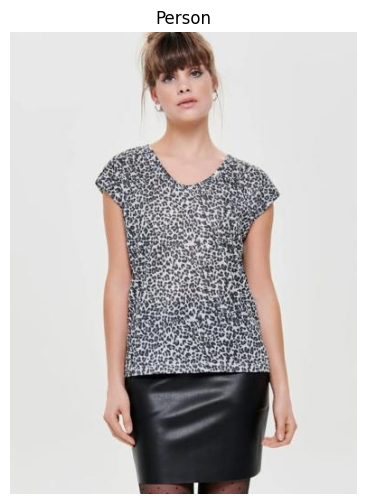

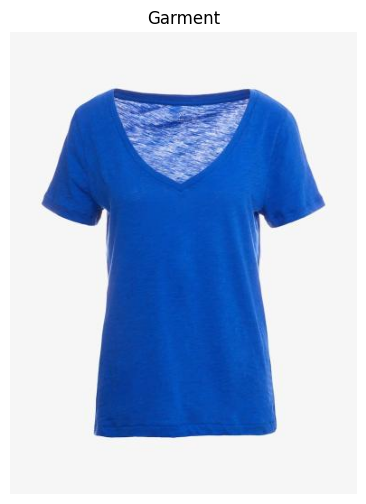

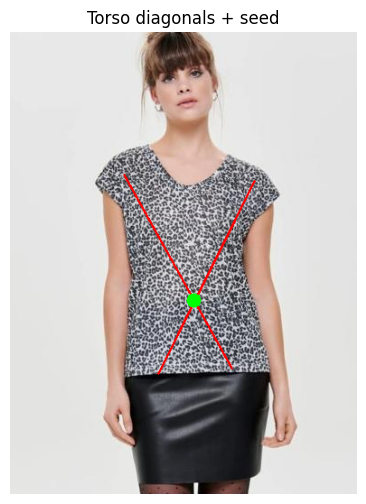

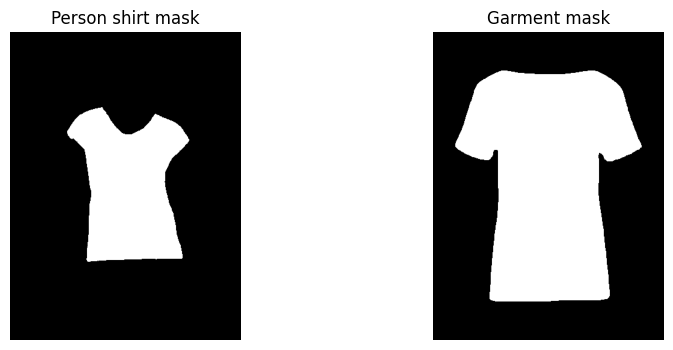

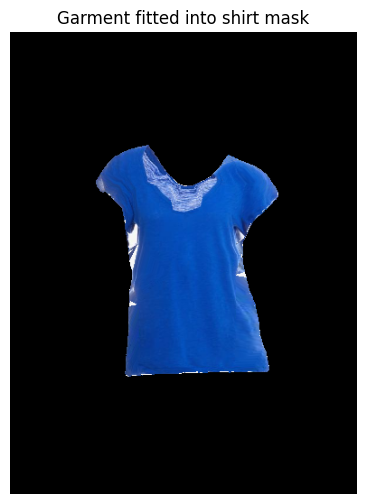

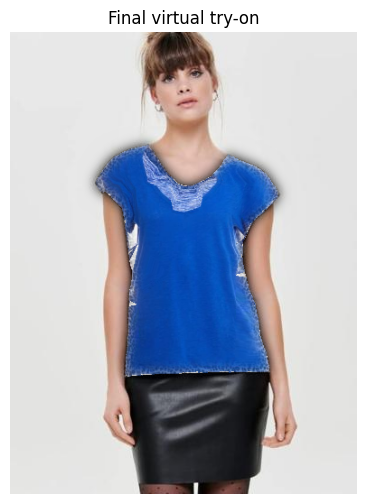

In [20]:
out, extras = virtual_try_on_exact(
    person_path="/content/image (2).jpg",
    garment_path="/content/image (1).jpg",
    sam_variant="vit_b",
    sam_checkpoint=None,
    device=None,
    visualize=True
)

# save result
Image.fromarray(out).save("/content/tryon_result.png")



this method seems to not work well when the SAM fails in correctly segmenting out the tshirt as can be seen below



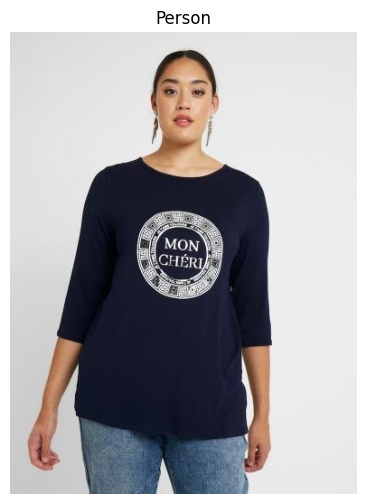

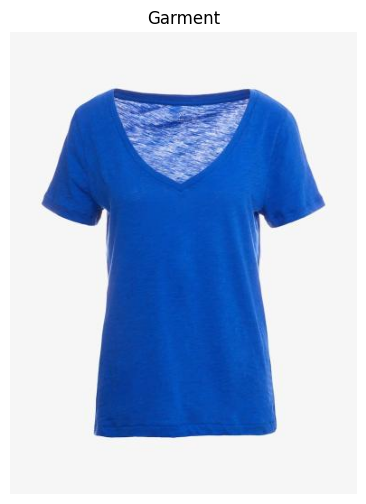

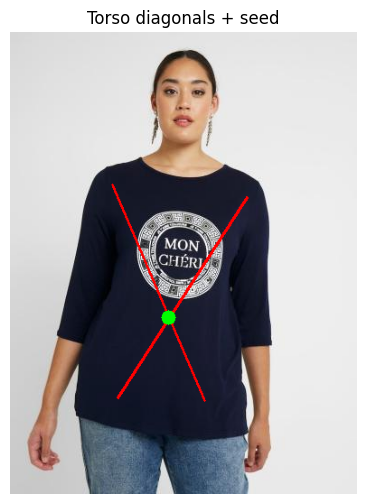

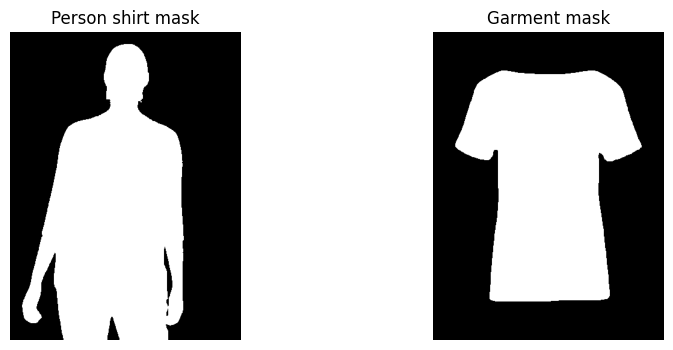

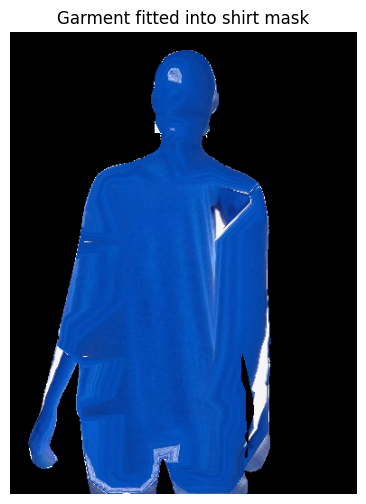

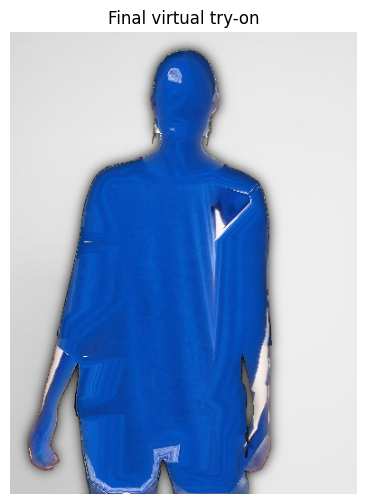

In [21]:
out, extras = virtual_try_on_exact(
    person_path="/content/image.jpg",
    garment_path="/content/image (1).jpg",
    sam_variant="vit_b",          # or "vit_h" if you prefer
    sam_checkpoint=None,          # auto-download vit_b if missing
    device=None,                  # auto "cuda" if available, else "cpu"
    visualize=True
)

# save result
Image.fromarray(out).save("/content/tryon_result.png")


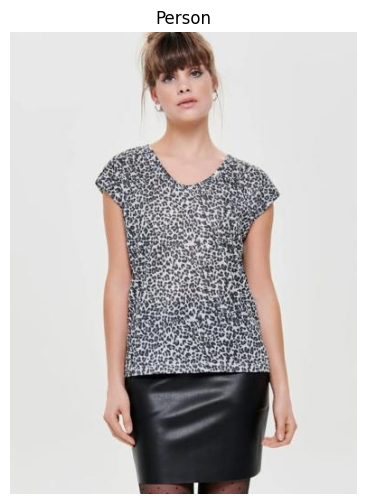

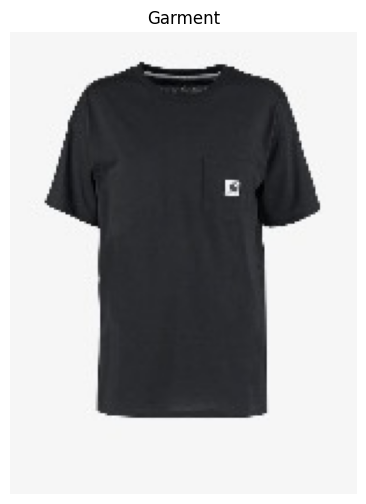

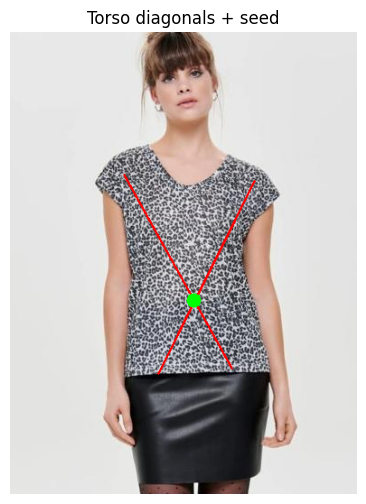

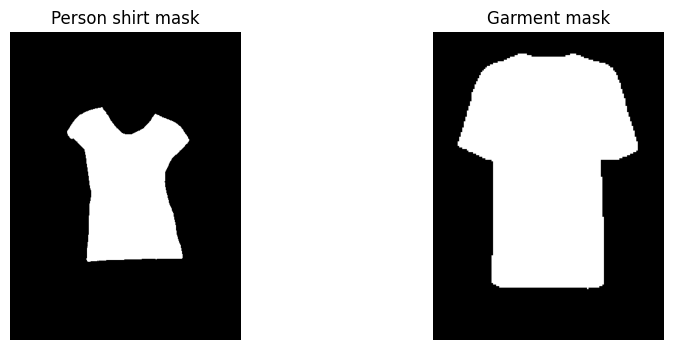

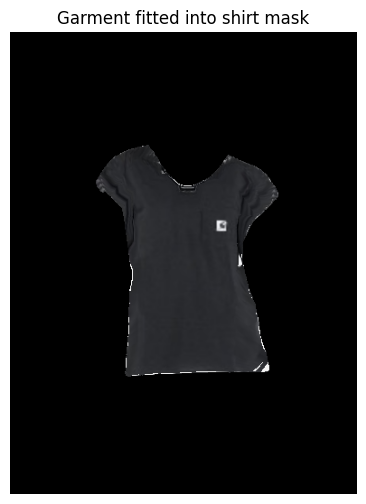

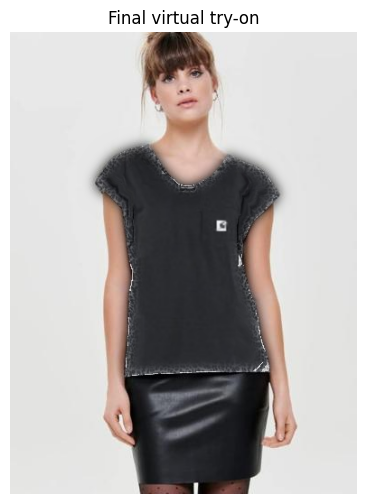

In [23]:
out, extras = virtual_try_on_exact(
    person_path="/content/image (2).jpg",
    garment_path="/content/download2.jpg",
    sam_variant="vit_b",          # or "vit_h" if you prefer
    sam_checkpoint=None,          # auto-download vit_b if missing
    device=None,                  # auto "cuda" if available, else "cpu"
    visualize=True
)

# save result
Image.fromarray(out).save("/content/tryon_result.png")


In [16]:
# ============================================
# Cell A: smart shirt mask with guided SAM
# ============================================
import numpy as np, cv2
import mediapipe as mp
from segment_anything import sam_model_registry, SamPredictor
import torch
import matplotlib.pyplot as plt

def _lm_xy(lm, idx, W, H):
    return (int(np.clip(lm[idx].x * W, 0, W-1)),
            int(np.clip(lm[idx].y * H, 0, H-1)))

def _build_torso_polygon_and_box(lm, W, H, pad_ratio=0.12):
    LS, RS, LH, RH = 11, 12, 23, 24
    p_ls = _lm_xy(lm, LS, W, H)
    p_rs = _lm_xy(lm, RS, W, H)
    p_lh = _lm_xy(lm, LH, W, H)
    p_rh = _lm_xy(lm, RH, W, H)

    # inset shoulders slightly to avoid grabbing arms
    shoulder_vec = np.array(p_rs) - np.array(p_ls)
    inset = max(4, int(0.06 * (np.linalg.norm(shoulder_vec) + 1e-6)))
    shoulder_dir = shoulder_vec / (np.linalg.norm(shoulder_vec) + 1e-6)
    p_ls_in = (int(p_ls[0] + inset*shoulder_dir[0]), int(p_ls[1]))
    p_rs_in = (int(p_rs[0] - inset*shoulder_dir[0]), int(p_rs[1]))

    torso_poly = np.array([p_ls_in, p_rs_in, p_rh, p_lh], dtype=np.int32)

    x0 = max(0, min(p_ls[0], p_rs[0], p_lh[0], p_rh[0]))
    y0 = max(0, min(p_ls[1], p_rs[1], p_lh[1], p_rh[1]))
    x1 = min(W-1, max(p_ls[0], p_rs[0], p_lh[0], p_rh[0]))
    y1 = min(H-1, max(p_ls[1], p_rs[1], p_lh[1], p_rh[1]))
    pad_x = int((x1 - x0) * pad_ratio)
    pad_y = int((y1 - y0) * pad_ratio)
    box = np.array([max(0, x0-pad_x), max(0, y0-pad_y),
                    min(W-1, x1+pad_x), min(H-1, y1+pad_y)], dtype=np.int32)
    return torso_poly, box, (p_ls, p_rs, p_lh, p_rh)

def _points_inside_polygon(poly, W, H, kx=4, ky=5):
    xs = np.linspace(poly[:,0].min(), poly[:,0].max(), kx+2, dtype=int)[1:-1]
    ys = np.linspace(poly[:,1].min(), poly[:,1].max(), ky+2, dtype=int)[1:-1]
    pos = []
    mask_poly = np.zeros((H, W), np.uint8)
    cv2.fillConvexPoly(mask_poly, poly, 255)
    for y in ys:
        for x in xs:
            if mask_poly[int(y), int(x)]:
                pos.append((int(x), int(y)))
    return pos

def _negative_points_from_landmarks(lm, W, H):
    # discourage head and lower body
    NOSE, L_ANK, R_ANK = 0, 27, 28
    neg = []
    try: neg.append(_lm_xy(lm, NOSE, W, H))
    except: pass
    try: neg.append(_lm_xy(lm, L_ANK, W, H))
    except: pass
    try: neg.append(_lm_xy(lm, R_ANK, W, H))
    except: pass
    return neg

def load_sam_predictor(variant="vit_b", checkpoint=None, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    if checkpoint is None:
        import os, urllib.request
        os.makedirs("weights", exist_ok=True)
        if variant == "vit_b":
            checkpoint = "weights/sam_vit_b_01ec64.pth"
            if not os.path.exists(checkpoint):
                print("Downloading SAM vit_b checkpoint...")
                urllib.request.urlretrieve(
                    "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth",
                    checkpoint
                )
        elif variant == "vit_h":
            checkpoint = "weights/sam_vit_h_4b8939.pth"
            if not os.path.exists(checkpoint):
                print("Downloading SAM vit_h checkpoint (~2.5GB)...")
                urllib.request.urlretrieve(
                    "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",
                    checkpoint
                )
        else:
            raise ValueError("variant must be 'vit_b' or 'vit_h'")
    sam = sam_model_registry[variant](checkpoint=checkpoint)
    sam.to(device)
    return SamPredictor(sam)

def smart_shirt_mask_with_sam(person_rgb, mp_results, predictor, visualize=False):
    """
    Build a robust t-shirt mask using SAM, guided by:
      - torso polygon + padded box from pose
      - multiple positive points inside torso
      - negative points (head/legs) to avoid full-body masks
      - choose best SAM mask by IoU with torso, then clean

    Returns:
        mask (H,W) uint8 in {0,1},
        info dict with debug visuals & guidance
    """
    H, W = person_rgb.shape[:2]
    if not mp_results.pose_landmarks:
        raise RuntimeError("No pose landmarks for smart shirt mask.")

    lm = mp_results.pose_landmarks.landmark
    torso_poly, box, (p_ls, p_rs, p_lh, p_rh) = _build_torso_polygon_and_box(lm, W, H)
    pos_pts = _points_inside_polygon(torso_poly, W, H, kx=4, ky=5)
    neg_pts = _negative_points_from_landmarks(lm, W, H)

    point_coords = np.array(pos_pts + neg_pts, dtype=np.float32)
    point_labels = np.array([1]*len(pos_pts) + [0]*len(neg_pts), dtype=np.int32)

    predictor.set_image(person_rgb)
    masks, scores, _ = predictor.predict(
        point_coords=point_coords if len(point_coords)>0 else None,
        point_labels=point_labels if len(point_coords)>0 else None,
        box=box[None, :],
        multimask_output=True
    )

    torso_mask = np.zeros((H,W), np.uint8)
    cv2.fillConvexPoly(torso_mask, torso_poly, 1)
    best_score, best_idx = -1, 0
    torso_area = torso_mask.sum()

    for i, m in enumerate(masks):
        m_u8 = (m>0).astype(np.uint8)
        inter = (m_u8 & torso_mask).sum()
        union = (m_u8 | torso_mask).sum()
        iou = inter / (union + 1e-8)
        area = m_u8.sum()
        size_penalty = np.exp(-max(0.0, (area/(torso_area+1e-8) - 1.3)))  # penalize too-large masks
        score = iou * size_penalty
        if score > best_score:
            best_score, best_idx = score, i

    raw = (masks[best_idx] > 0).astype(np.uint8)
    refined = (raw & torso_mask).astype(np.uint8)
    refined = cv2.morphologyEx(refined, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))
    refined = cv2.morphologyEx(refined, cv2.MORPH_CLOSE, np.ones((9,9), np.uint8))

    info = dict(
        torso_poly=torso_poly,
        box=box,
        pos_pts=pos_pts,
        neg_pts=neg_pts,
        raw_mask=raw,
        torso_mask=torso_mask
    )

    if visualize:
        vis = person_rgb.copy()
        cv2.rectangle(vis, (box[0],box[1]), (box[2],box[3]), (0,255,0), 2)
        if len(pos_pts):
            for x,y in pos_pts: cv2.circle(vis,(x,y),4,(0,255,0),-1)
        if len(neg_pts):
            for x,y in neg_pts: cv2.circle(vis,(x,y),4,(255,0,0),-1)
        cv2.polylines(vis, [torso_poly], True, (255,255,0), 2)

        plt.figure(figsize=(14,4))
        plt.subplot(1,3,1); plt.imshow(vis); plt.title("Guidance (box+points+torso)"); plt.axis('off')
        plt.subplot(1,3,2); plt.imshow(raw, cmap='gray'); plt.title("Best SAM mask"); plt.axis('off')
        plt.subplot(1,3,3); plt.imshow(refined, cmap='gray'); plt.title("Refined shirt mask"); plt.axis('off')
        plt.show()

    return refined, info


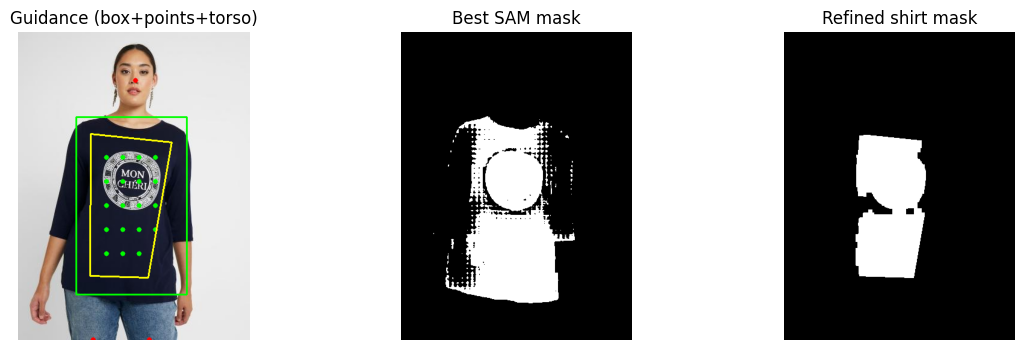

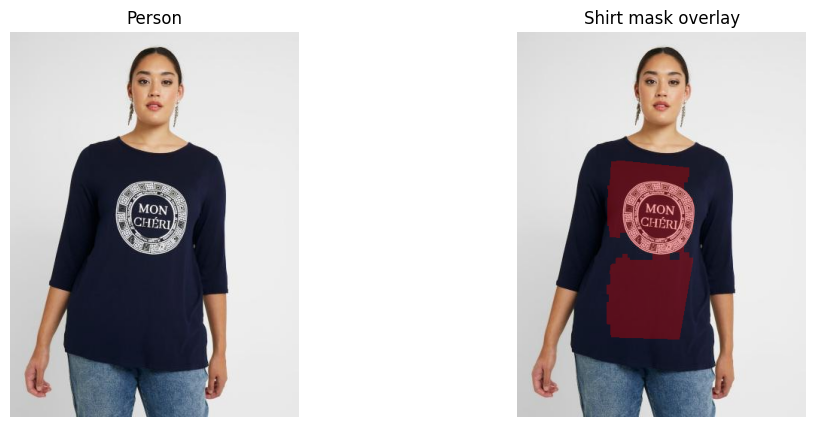

Mask shape: (512, 384) | Foreground pixels: 23228


In [17]:
# ============================================
# Cell B: Use the function and show output
# ============================================
import cv2, numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

# 1) load your person image
PERSON_IMG_PATH = "/content/image.jpg"  # <-- replace
person_bgr = cv2.imread(PERSON_IMG_PATH, cv2.IMREAD_COLOR)
assert person_bgr is not None, "/content/image (1).jpg."
person_rgb = cv2.cvtColor(person_bgr, cv2.COLOR_BGR2RGB)

# 2) mediapipe pose
mp_pose = mp.solutions.pose
with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5) as pose:
    results = pose.process(person_rgb)

# 3) load SAM predictor (vit_b is fast & good)
predictor = load_sam_predictor(variant="vit_b")

# 4) get smart shirt mask
shirt_mask, dbg = smart_shirt_mask_with_sam(person_rgb, results, predictor, visualize=True)

# 5) visualize final mask overlay on the person
overlay = person_rgb.copy()
overlay[shirt_mask.astype(bool)] = (0.7*overlay[shirt_mask.astype(bool)] + 0.3*np.array([255,0,0])).astype(np.uint8)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(person_rgb); plt.title("Person"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(overlay);     plt.title("Shirt mask overlay"); plt.axis('off')
plt.show()

print("Mask shape:", shirt_mask.shape, "| Foreground pixels:", int(shirt_mask.sum()))
